In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

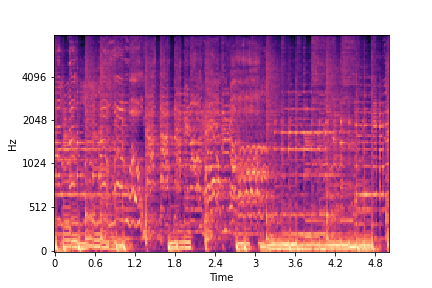

(432, 288)


In [3]:
# try to get one of the images inside the file
with Image.open('SplitmelSpect/train/rock/11.png') as im:
    display(im)
    print(im.size)

In [4]:
transform = transforms.ToTensor()
root ="SplitmelSpect"

train_data = datasets.ImageFolder(os.path.join(root,"train"), transform= transform)
test_data = datasets.ImageFolder(os.path.join(root, "test"), transform = transform)

torch.manual_seed(30)

train_loader = DataLoader(train_data, batch_size=10,shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes

In [5]:
class_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [6]:
len(train_data)

1797

In [7]:
len(test_data)

1200

Labels:  [3 2 7 5 3 0 8 1 5 1]
Class:  disco country pop jazz disco blues reggae classical jazz classical


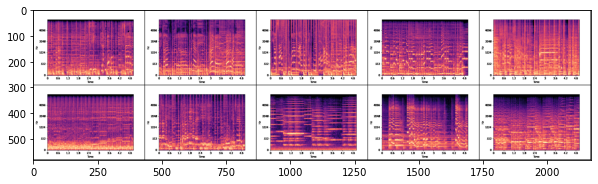

In [8]:
for images, labels in train_loader:
    break
    

print('Labels: ', labels.numpy())
print('Class: ',*np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [9]:
images[0].shape

torch.Size([3, 288, 432])

In [10]:
print((((288-2)/2)-2)/2)
print(((430/2)-2)/2)
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(70*106*16, 120)   
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1,70*106*16) # flatten
        X = F.dropout(X,p=0.2)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.2)
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

70.5
106.5


In [11]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=118720, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
14246400
120
10080
84
840
10


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) ## stochiastic gradient descent

In [14]:
import time
start_time = time.time()

epochs = 50

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
       
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:4}  batch: {b:4} [{10*b:6}/600]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.data.item())
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.data.item())
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

epoch:    0  batch:   10 [   100/600]  loss: 2.42919469  accuracy:   9.000%
epoch:    0  batch:   20 [   200/600]  loss: 2.37405443  accuracy:   8.000%
epoch:    0  batch:   30 [   300/600]  loss: 2.28950262  accuracy:   9.667%
epoch:    0  batch:   40 [   400/600]  loss: 2.26839876  accuracy:  10.000%
epoch:    0  batch:   50 [   500/600]  loss: 2.27968097  accuracy:  10.400%
epoch:    0  batch:   60 [   600/600]  loss: 2.29225206  accuracy:  10.333%
epoch:    0  batch:   70 [   700/600]  loss: 2.25265169  accuracy:  11.000%
epoch:    0  batch:   80 [   800/600]  loss: 2.27536917  accuracy:  10.375%
epoch:    0  batch:   90 [   900/600]  loss: 2.29753828  accuracy:  10.778%
epoch:    0  batch:  100 [  1000/600]  loss: 2.18823767  accuracy:  11.200%
epoch:    0  batch:  110 [  1100/600]  loss: 2.28994703  accuracy:  11.364%
epoch:    0  batch:  120 [  1200/600]  loss: 2.27998734  accuracy:  11.167%
epoch:    0  batch:  130 [  1300/600]  loss: 2.23563433  accuracy:  11.538%
epoch:    0 

epoch:    6  batch:   10 [   100/600]  loss: 0.87761289  accuracy:  76.000%
epoch:    6  batch:   20 [   200/600]  loss: 1.44017959  accuracy:  75.500%
epoch:    6  batch:   30 [   300/600]  loss: 0.76836407  accuracy:  75.000%
epoch:    6  batch:   40 [   400/600]  loss: 0.92115724  accuracy:  75.500%
epoch:    6  batch:   50 [   500/600]  loss: 0.62219024  accuracy:  74.400%
epoch:    6  batch:   60 [   600/600]  loss: 0.67188615  accuracy:  74.333%
epoch:    6  batch:   70 [   700/600]  loss: 0.52441514  accuracy:  74.571%
epoch:    6  batch:   80 [   800/600]  loss: 0.41361722  accuracy:  74.625%
epoch:    6  batch:   90 [   900/600]  loss: 0.49590451  accuracy:  75.222%
epoch:    6  batch:  100 [  1000/600]  loss: 0.67617512  accuracy:  74.900%
epoch:    6  batch:  110 [  1100/600]  loss: 0.87362051  accuracy:  74.273%
epoch:    6  batch:  120 [  1200/600]  loss: 1.20560670  accuracy:  74.917%
epoch:    6  batch:  130 [  1300/600]  loss: 0.62187225  accuracy:  75.077%
epoch:    6 

epoch:   12  batch:   10 [   100/600]  loss: 0.38418928  accuracy:  90.000%
epoch:   12  batch:   20 [   200/600]  loss: 0.06285110  accuracy:  91.500%
epoch:   12  batch:   30 [   300/600]  loss: 0.03111445  accuracy:  93.000%
epoch:   12  batch:   40 [   400/600]  loss: 0.27101773  accuracy:  93.000%
epoch:   12  batch:   50 [   500/600]  loss: 0.04520116  accuracy:  92.800%
epoch:   12  batch:   60 [   600/600]  loss: 0.02130293  accuracy:  93.000%
epoch:   12  batch:   70 [   700/600]  loss: 0.34942347  accuracy:  92.714%
epoch:   12  batch:   80 [   800/600]  loss: 0.30092517  accuracy:  93.000%
epoch:   12  batch:   90 [   900/600]  loss: 0.12193833  accuracy:  93.111%
epoch:   12  batch:  100 [  1000/600]  loss: 0.29958686  accuracy:  92.900%
epoch:   12  batch:  110 [  1100/600]  loss: 0.20792007  accuracy:  93.000%
epoch:   12  batch:  120 [  1200/600]  loss: 0.18735833  accuracy:  93.167%
epoch:   12  batch:  130 [  1300/600]  loss: 0.02537305  accuracy:  93.308%
epoch:   12 

epoch:   18  batch:   10 [   100/600]  loss: 0.01371367  accuracy:  97.000%
epoch:   18  batch:   20 [   200/600]  loss: 0.00947279  accuracy:  96.000%
epoch:   18  batch:   30 [   300/600]  loss: 0.01521031  accuracy:  97.000%
epoch:   18  batch:   40 [   400/600]  loss: 0.00962198  accuracy:  97.500%
epoch:   18  batch:   50 [   500/600]  loss: 0.15118597  accuracy:  97.200%
epoch:   18  batch:   60 [   600/600]  loss: 0.08494176  accuracy:  97.000%
epoch:   18  batch:   70 [   700/600]  loss: 0.23407499  accuracy:  97.000%
epoch:   18  batch:   80 [   800/600]  loss: 0.43857175  accuracy:  97.000%
epoch:   18  batch:   90 [   900/600]  loss: 0.08988260  accuracy:  97.000%
epoch:   18  batch:  100 [  1000/600]  loss: 0.01459157  accuracy:  97.200%
epoch:   18  batch:  110 [  1100/600]  loss: 0.02127700  accuracy:  97.273%
epoch:   18  batch:  120 [  1200/600]  loss: 0.07468669  accuracy:  97.333%
epoch:   18  batch:  130 [  1300/600]  loss: 0.59851980  accuracy:  97.154%
epoch:   18 

epoch:   24  batch:   10 [   100/600]  loss: 0.26389521  accuracy:  97.000%
epoch:   24  batch:   20 [   200/600]  loss: 0.04732811  accuracy:  96.000%
epoch:   24  batch:   30 [   300/600]  loss: 0.05004127  accuracy:  96.667%
epoch:   24  batch:   40 [   400/600]  loss: 0.40109181  accuracy:  96.750%
epoch:   24  batch:   50 [   500/600]  loss: 0.28353864  accuracy:  96.800%
epoch:   24  batch:   60 [   600/600]  loss: 0.00006875  accuracy:  97.333%
epoch:   24  batch:   70 [   700/600]  loss: 0.03968655  accuracy:  97.571%
epoch:   24  batch:   80 [   800/600]  loss: 0.06006994  accuracy:  97.500%
epoch:   24  batch:   90 [   900/600]  loss: 0.05188433  accuracy:  97.556%
epoch:   24  batch:  100 [  1000/600]  loss: 0.10143092  accuracy:  97.200%
epoch:   24  batch:  110 [  1100/600]  loss: 0.00340125  accuracy:  97.273%
epoch:   24  batch:  120 [  1200/600]  loss: 0.00342476  accuracy:  97.333%
epoch:   24  batch:  130 [  1300/600]  loss: 0.00861785  accuracy:  97.000%
epoch:   24 

epoch:   30  batch:   10 [   100/600]  loss: 0.11111355  accuracy:  97.000%
epoch:   30  batch:   20 [   200/600]  loss: 0.02598665  accuracy:  98.500%
epoch:   30  batch:   30 [   300/600]  loss: 0.05026738  accuracy:  98.667%
epoch:   30  batch:   40 [   400/600]  loss: 0.01340582  accuracy:  98.250%
epoch:   30  batch:   50 [   500/600]  loss: 0.06184549  accuracy:  98.000%
epoch:   30  batch:   60 [   600/600]  loss: 0.02558734  accuracy:  98.000%
epoch:   30  batch:   70 [   700/600]  loss: 0.00164239  accuracy:  98.143%
epoch:   30  batch:   80 [   800/600]  loss: 0.00908784  accuracy:  98.000%
epoch:   30  batch:   90 [   900/600]  loss: 0.00945478  accuracy:  97.667%
epoch:   30  batch:  100 [  1000/600]  loss: 0.09500702  accuracy:  97.500%
epoch:   30  batch:  110 [  1100/600]  loss: 0.00231888  accuracy:  97.182%
epoch:   30  batch:  120 [  1200/600]  loss: 0.13447307  accuracy:  97.333%
epoch:   30  batch:  130 [  1300/600]  loss: 0.13974303  accuracy:  97.385%
epoch:   30 

epoch:   36  batch:   10 [   100/600]  loss: 0.01982110  accuracy:  96.000%
epoch:   36  batch:   20 [   200/600]  loss: 0.77018464  accuracy:  95.000%
epoch:   36  batch:   30 [   300/600]  loss: 0.25270277  accuracy:  95.333%
epoch:   36  batch:   40 [   400/600]  loss: 0.07430230  accuracy:  96.000%
epoch:   36  batch:   50 [   500/600]  loss: 0.06382655  accuracy:  96.200%
epoch:   36  batch:   60 [   600/600]  loss: 0.05678396  accuracy:  96.333%
epoch:   36  batch:   70 [   700/600]  loss: 0.19693795  accuracy:  96.429%
epoch:   36  batch:   80 [   800/600]  loss: 0.00979228  accuracy:  96.875%
epoch:   36  batch:   90 [   900/600]  loss: 0.22508354  accuracy:  97.111%
epoch:   36  batch:  100 [  1000/600]  loss: 0.00462535  accuracy:  97.100%
epoch:   36  batch:  110 [  1100/600]  loss: 0.00029099  accuracy:  97.273%
epoch:   36  batch:  120 [  1200/600]  loss: 0.04253222  accuracy:  97.333%
epoch:   36  batch:  130 [  1300/600]  loss: 0.00105409  accuracy:  97.462%
epoch:   36 

epoch:   42  batch:   10 [   100/600]  loss: 0.00023538  accuracy: 100.000%
epoch:   42  batch:   20 [   200/600]  loss: 0.27420712  accuracy:  98.000%
epoch:   42  batch:   30 [   300/600]  loss: 0.00683161  accuracy:  97.667%
epoch:   42  batch:   40 [   400/600]  loss: 0.01362126  accuracy:  98.000%
epoch:   42  batch:   50 [   500/600]  loss: 0.02833475  accuracy:  97.600%
epoch:   42  batch:   60 [   600/600]  loss: 0.01260995  accuracy:  97.833%
epoch:   42  batch:   70 [   700/600]  loss: 0.00134828  accuracy:  98.000%
epoch:   42  batch:   80 [   800/600]  loss: 0.00096396  accuracy:  97.875%
epoch:   42  batch:   90 [   900/600]  loss: 0.00047746  accuracy:  97.889%
epoch:   42  batch:  100 [  1000/600]  loss: 0.02938848  accuracy:  97.900%
epoch:   42  batch:  110 [  1100/600]  loss: 0.25239915  accuracy:  97.818%
epoch:   42  batch:  120 [  1200/600]  loss: 0.00043464  accuracy:  97.833%
epoch:   42  batch:  130 [  1300/600]  loss: 0.00024152  accuracy:  97.769%
epoch:   42 

epoch:   48  batch:   10 [   100/600]  loss: 0.05348884  accuracy:  97.000%
epoch:   48  batch:   20 [   200/600]  loss: 1.27817285  accuracy:  96.000%
epoch:   48  batch:   30 [   300/600]  loss: 0.14812638  accuracy:  95.667%
epoch:   48  batch:   40 [   400/600]  loss: 0.00022408  accuracy:  95.000%
epoch:   48  batch:   50 [   500/600]  loss: 0.02976426  accuracy:  95.600%
epoch:   48  batch:   60 [   600/600]  loss: 0.07518394  accuracy:  95.833%
epoch:   48  batch:   70 [   700/600]  loss: 0.02612190  accuracy:  96.286%
epoch:   48  batch:   80 [   800/600]  loss: 0.11872578  accuracy:  96.500%
epoch:   48  batch:   90 [   900/600]  loss: 0.01320974  accuracy:  96.667%
epoch:   48  batch:  100 [  1000/600]  loss: 0.00397852  accuracy:  96.800%
epoch:   48  batch:  110 [  1100/600]  loss: 0.00243279  accuracy:  97.000%
epoch:   48  batch:  120 [  1200/600]  loss: 0.01550142  accuracy:  97.083%
epoch:   48  batch:  130 [  1300/600]  loss: 0.00515971  accuracy:  97.077%
epoch:   48 

In [15]:
# training accuracy peaked and decreased -> do early stopping
# epoch:    4  batch:  170 [  1700/600]  loss: 0.26048362  accuracy:  80.059%
# epoch:    4  batch:  180 [  1800/600]  loss: 0.33563253  accuracy:  79.722%

In [16]:
torch.save(model.state_dict(), 'CNN Model')

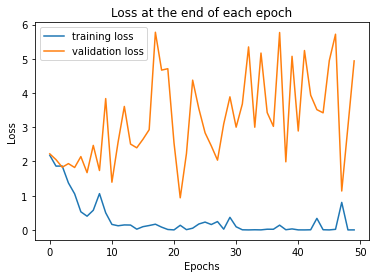

In [17]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss at the end of each epoch')
plt.legend()



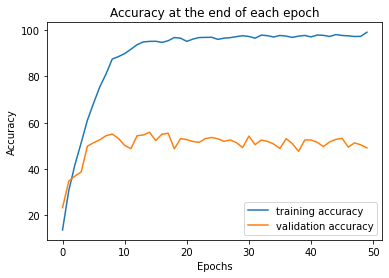

In [18]:
plt.plot([t.item()*100/1797 for t in train_correct], label='training accuracy')
plt.plot([t.item()*100/1200 for t in test_correct], label='validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy at the end of each epoch')
plt.legend();